In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from keras.applications import vgg16,vgg19,resnet
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_47/3993855440.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [3]:
import os
import numpy as np
from PIL import Image

def read_images_from_folders(base_folder, folder_names):
    images = []
    labels = []
    label_num = 0
    image_width=128
    image_height=128
    
    for folder in sorted(os.listdir(base_folder)):
        if folder in folder_names:
            folder_path = os.path.join(base_folder, folder)
            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, filename)
                    try:
                        img = Image.open(img_path)
                        img = img.resize((image_width, image_height))  # Resize images if necessary
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(label_num)
                    except Exception as e:
                        print(f"Error reading image: {img_path} - {e}")
                label_num += 1
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [4]:
# Example usage:
base_folder = '/kaggle/input/malayakew-plant-leaf-dataset/MK/D1/train'
class_folders = ['Class (17)', 'Class (18)']  # Replace with the folder names you want to read
X_train, y_train = read_images_from_folders(base_folder, class_folders)
base_folder = '/kaggle/input/malayakew-plant-leaf-dataset/MK/D1/test'
X_test, y_test = read_images_from_folders(base_folder, class_folders)

In [5]:
print("Images shape:", X_train.shape)
print("Labels shape:", y_train.shape)
print("Images shape:", X_test.shape)
print("Labels shape:", y_test.shape)

Images shape: (104, 128, 128, 3)
Labels shape: (104,)
Images shape: (24, 128, 128, 3)
Labels shape: (24,)


In [6]:
X_train = X_train/255
X_test = X_test/255

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to apply augmentation twice to each dataset
def augment_dataset(dataset):
    augmented_data = []
    for img in dataset:
        img = np.expand_dims(img, axis=0)  # Expanding dimensions for batch size
        for _ in range(3):  # Apply augmentation twice
            seed = np.random.randint(0, 1000)  # Different seed for each pass
            for batch in datagen.flow(img, batch_size=1, seed=seed):
                augmented_data.append(np.squeeze(batch))  # Remove the batch dimension
                break  # Stop the loop after one augmented image
    return np.array(augmented_data)

# Apply augmentation twice to X_train, X_test, and X_val
X_train_augmented = augment_dataset(X_train)
# X_test_augmented = augment_dataset(X_test)
#X_val_augmented = augment_dataset(X_val)
y_train_augmented = np.repeat(y_train, 3, axis=0)  # Adjust based on augmentation factor
# y_test_augmented = np.repeat(y_test, 3, axis=0)  # Adjust based on augmentation factor



# Check the shapes of augmented datasets
print("X_train_augmented shape:", X_train_augmented.shape)
# print("X_test_augmented shape:", X_test_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
# print("y_test_augmented shape:", y_test_augmented.shape)

X_train_augmented shape: (312, 128, 128, 3)
y_train_augmented shape: (312,)


In [8]:
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (104, 128, 128, 3)
X_test Shape:  (24, 128, 128, 3)
y_train Shape:  (104,)
y_test Shape:  (24,)


In [9]:
from sklearn.utils import shuffle

# Combine original data with augmented data
X_train_combined = np.concatenate((X_train, X_train_augmented))
y_train_combined = np.concatenate((y_train, y_train_augmented))

# X_test_combined = np.concatenate((X_test, X_test_augmented))
# y_test_combined = np.concatenate((y_test, y_test_augmented))


# Shuffle the combined data
X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined, random_state=42)
# X_test_combined, y_test_combined = shuffle(X_test_combined, y_test_combined, random_state=42)

In [11]:
X_train_combined.shape


(416, 128, 128, 3)

**Xception**

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception
import keras_tuner as kt

def build_model(hp):
    google_base = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Freeze all layers except the last 4 convolutional blocks
    for layer in google_base.layers:
        layer.trainable = False
#     res_base.trainable= True
    
    model = models.Sequential()
    model.add(google_base)
    model.add(layers.Flatten())
    
     # Tune FC layer units and dropout rate
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.5, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.4, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.5, max_value=0.9, step=0.1)))
 
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
#     optimizer = hp.Choice(name='optimizer',values=['rmsprop','adam','adagrad','sgd','adadelta'])
    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
#         tf.keras.metrics.Accuracy(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.SensitivityAtSpecificity(0.5),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.F1Score()

    ]
    model.compile(
        optimizer = 'adam',
#         loss =  "sparse_categorical_crossentropy",
        loss='binary_crossentropy',
        metrics=metrics
        
    )
    
    return model


**mobile net**

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import regularizers

def build_model(hp):
    # Load pre-trained MobileNet model
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the layers of the pre-trained MobileNet
    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-3:]:
        layer.trainable = True

    model = keras.Sequential()

    # Add the pre-trained MobileNet model
    model.add(base_model)

    # Flatten the output of MobileNet
    model.add(keras.layers.GlobalAveragePooling2D())

    hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units', min_value=32, max_value=256, step=32)
    hp_units3 = hp.Int('units', min_value=32, max_value=128, step=16)


    model.add(layers.Dense(units=hp_units1, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=hp_units1, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(units=hp_units2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=hp_units2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=hp_units2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=hp_units3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Hyperparameter for learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.SensitivityAtSpecificity(0.5),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.F1Score()]

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=metrics)

    return model

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

objective = kt.Objective(
name="val_accuracy",
direction="max")

tuner = kt.GridSearch(
    build_model,
    objective=objective,
    max_trials = 20,
    executions_per_trial=5,
    directory="mnist_kt_test",
    overwrite=True,
)

tuner.search_space_summary()
tuner.search(X_train_combined, y_train_combined.astype('float32'), epochs=5,validation_split=0.22)

Trial 20 Complete [00h 00m 53s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 18m 02s


In [15]:
print(model.summary())

NameError: name 'model' is not defined

In [12]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp)
best_model = tuner.hypermodel.build(best_hp)

In [13]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('plants_xception.h5',save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=3
    )
]
history = best_model.fit(X_train_combined, y_train_combined.astype('float32'), epochs=50,batch_size=32,validation_split=0.22,callbacks=callbacks)

Epoch 1/50
 9/11 [=======================>......] - ETA: 0s - loss: 4.6043 - accuracy: 0.5556 - auc_1: 0.5316 - recall_1: 0.4823 - precision_1: 0.5528 - specificity_at_sensitivity_1: 0.5782 - sensitivity_at_specificity_1: 0.5603 - false_negatives_1: 73.0000 - false_positives_1: 55.0000 - true_negatives_1: 92.0000 - true_positives_1: 68.0000 - f1_score: 0.6573

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 8s 184ms/step - loss: 4.5068 - accuracy: 0.5494 - auc_1: 0.5343 - recall_1: 0.4688 - precision_1: 0.5515 - specificity_at_sensitivity_1: 0.5732 - sensitivity_at_specificity_1: 0.5562 - false_negatives_1: 85.0000 - false_positives_1: 61.0000 - true_negatives_1: 103.0000 - true_positives_1: 75.0000 - f1_score: 0.6612 - val_loss: 3.3060 - val_accuracy: 0.9674 - val_auc_1: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 0.9412 - val_specificity_at_sensitivity_1: 1.0000 - val_sensitivity_at_specificity_1: 1.0000 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 3.0000 - val_true_negatives_1: 41.0000 - val_true_positives_1: 48.0000 - val_f1_score: 0.6857
Epoch 2/50
11/11 [==============================] - 1s 52ms/step - loss: 3.1401 - accuracy: 0.6358 - auc_1: 0.7063 - recall_1: 0.5875 - precision_1: 0.6438 - specificity_at_sensitivity_1: 0.7378 - sensitivity_at_specificity_1: 0.8062 - false_negatives_1: 66.0000 - false_positives_1: 52.000

In [14]:
best_model.evaluate(X_test,y_test.astype('float32'))

1/1 [==============================] - 0s 422ms/step - loss: 1.1355 - accuracy: 1.0000 - auc_1: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000 - specificity_at_sensitivity_1: 1.0000 - sensitivity_at_specificity_1: 1.0000 - false_negatives_1: 0.0000e+00 - false_positives_1: 0.0000e+00 - true_negatives_1: 12.0000 - true_positives_1: 12.0000 - f1_score: 1.0000


[1.1354516744613647,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 12.0,
 12.0,
 array([1.], dtype=float32)]

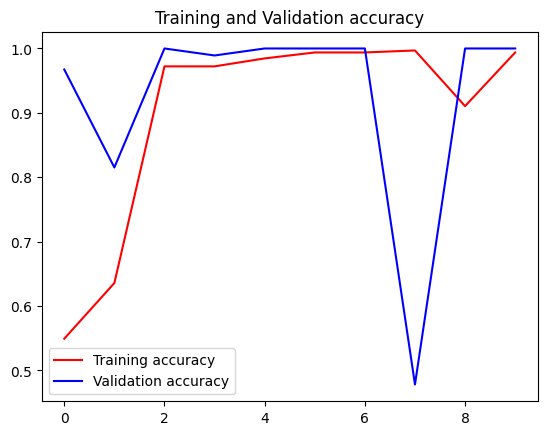

<Figure size 640x480 with 0 Axes>

In [15]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

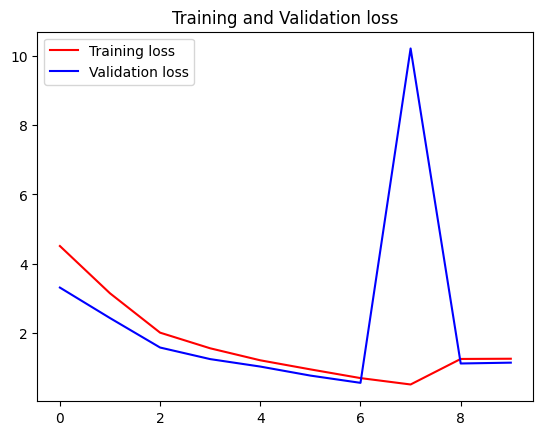

<Figure size 640x480 with 0 Axes>

In [16]:
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

13/13 [==============================] - 0s 17ms/step


Text(70.72222222222221, 0.5, 'True Labels')

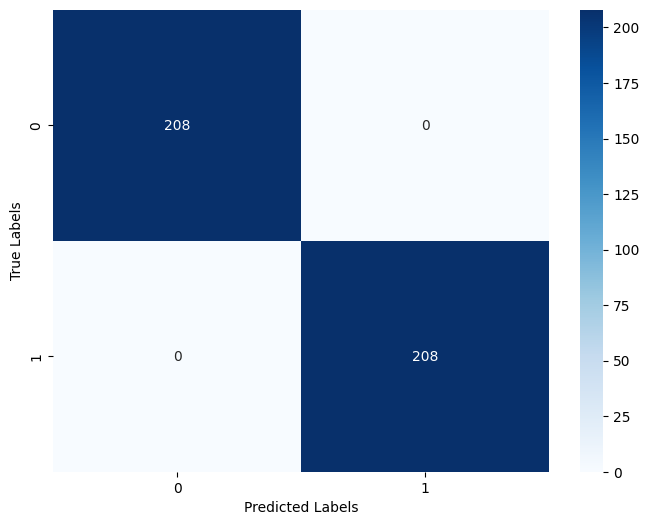

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


pred1 = best_model.predict(X_train_combined)
# Compute confusion matrix
Xcept_matrix = confusion_matrix(y_train_combined, np.where(pred1 >= 0.5, 1, 0))


# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(Xcept_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')